In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
from nltk.cluster import KMeansClusterer
import nltk

from node2vec import Node2Vec

sns.set_style('whitegrid')

In [2]:
dimensions = 128
walk_length = 80
num_walks = 10
p = 1.0
q = 1.0
workers = 4

window = 10
min_count = 1
seed = 0

In [3]:
colors_dic = {
    0:'red',
    1:'orange',
    2:'black',
    3:'green',
    4:'blue'
    }

In [4]:
def count_embeddings(G,labels,dimensions,walk_length,num_walks,p,q,workers,window,min_count,seed):
    n2v = Node2Vec(G, 
               dimensions = dimensions, 
               walk_length = walk_length,
               num_walks = num_walks,
               p = p,
               q = q,
               workers = workers
              )
    model = n2v.fit(window = window, 
                          min_count = min_count,
                          seed = seed
                         )
    model_nodes = list(model.wv.vocab)

    return model,model_nodes

def to2d(embedding_clusters,perplexity):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape

    tsne_model_en_2d = TSNE(perplexity=perplexity, n_components=2, random_state=seed)
    embeddings_en_2d = np.array(
    tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
    return embeddings_en_2d

def assign_colors(model_nodes,labels):
    colors = []
    for i in model_nodes:
        colors.append(colors_dic[labels.loc[int(i)]['label']])
    return colors

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, colors, a, filename=None):
    plt.figure(figsize=(16, 9))
    
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=colors_dic[label], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=1, xy=(x[i]+2, y[i]+2), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=12)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()
    
def count_scores(labels, clusters):
    f1_micro = metrics.f1_score(labels,clusters,average='micro')
    adj_score = metrics.adjusted_rand_score(labels,clusters)
    return f1_micro, adj_score

In [5]:
def make_graph(labels, edges):
    G = nx.Graph()
    G.add_nodes_from(labels['node'])

    for i, row in edges.iterrows():
        G.add_edge(row['from'],row['to'], weight=1)
    return G

def draw_g(G):
    pos = nx.spring_layout(G)
    nx.draw(G, pos=pos, with_labels=True, seed=seed)

# 1. Manager's edges
Each member send email to his coworker + managers in each group send an email to every manager from those groups

In [6]:
m_edges = pd.read_csv('../data/clear_cluster_test/managers_edges.csv', header=None, names=('from','to'))
labels = pd.read_csv('../data/clear_cluster_test/labels.csv', header=None, 
                     names=('node','label','label+'))
labels_list = list(labels['label'].unique())

n_clusters = len(labels['label'].unique())

In [7]:
m_G = make_graph(labels, m_edges)

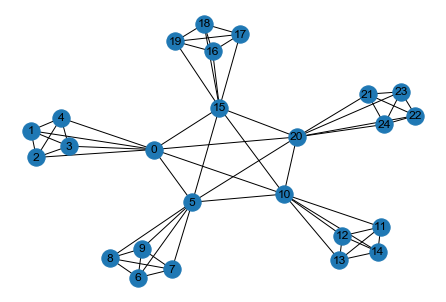

In [8]:
draw_g(m_G)

In [9]:
m_model,m_model_nodes = count_embeddings(m_G,labels,dimensions,
                                                                  walk_length,num_walks,p,q,workers,
                                                                  window,min_count,seed)

Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 5004.90it/s]


In [10]:
known_labels = []

for i in m_model.wv.index2word:
    known_labels.append(labels.loc[int(i)]['label'])
    
known_labels

[4, 3, 2, 1, 0, 4, 4, 4, 4, 3, 3, 2, 3, 3, 2, 2, 2, 0, 1, 1, 0, 1, 0, 1, 0]

In [11]:
# most_similar()
keys = list(range(0,24,5)) # the first node of each group

embedding_clusters = []
word_clusters = []
for word in keys:
    print('word ',word)
    embeddings = []
    words = []
    embeddings.append(m_model[str(word)]) # adding vector of the first(key) node
    words.append(str(word)) # adding vector of the first(key) node
    for similar_word, prob in m_model.most_similar(str(word), topn=4):
        words.append(similar_word)
        print(similar_word)
        embeddings.append(m_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

word  0
1
2
4
3
word  5
9
8
6
7
word  10
12
11
13
14
word  15
19
18
16
17
word  20
23
21
24
22


In [12]:
embedding_clusters

[[array([ 0.08937506,  0.15199597, -0.12150294,  0.00385017, -0.12456755,
         -0.08506268, -0.15088408,  0.21088177,  0.20993577, -0.09115588,
          0.17655127, -0.18698506,  0.07170043,  0.17002037, -0.17227584,
         -0.3929722 , -0.11596969, -0.10959842, -0.07262728,  0.02433664,
          0.02448597,  0.02894217, -0.11315093, -0.17683832, -0.14149879,
         -0.16847865,  0.33384094, -0.07827352,  0.14396608, -0.12805846,
          0.19671416,  0.06549774, -0.06868383,  0.04593509, -0.06041563,
         -0.06943712,  0.24445091, -0.2770495 ,  0.08177847, -0.14321691,
         -0.33647683,  0.01226156, -0.35829762,  0.01186102,  0.2411511 ,
         -0.11455714,  0.16416916, -0.1190691 , -0.008695  , -0.05643745,
          0.29391855, -0.22281456, -0.11692563,  0.05148906, -0.17161989,
         -0.06040676, -0.21257755, -0.15748727,  0.11506757,  0.10149734,
          0.06684478,  0.00181689,  0.0744226 , -0.07862361,  0.426545  ,
          0.08895256,  0.0176273 ,  0.

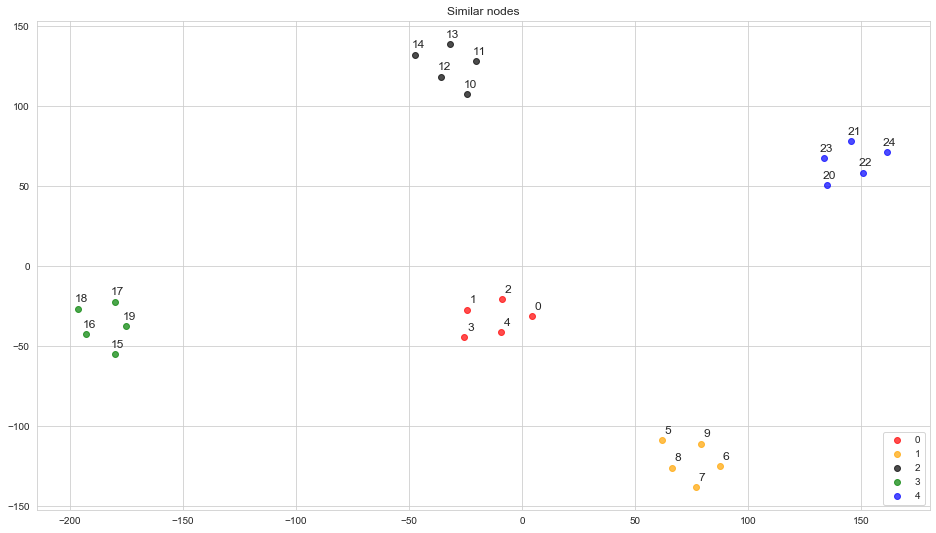

In [13]:
model_en_2d = to2d(embedding_clusters,5)
colors = assign_colors(m_model_nodes,labels)
tsne_plot_similar_words('Similar nodes', labels_list, model_en_2d, word_clusters, colors, 0.7)

In [14]:
# kmeans + init
kmean_init = []
# init kmeans centroids with the first nodes of each cluster: 
# keys = [0, 5, 10, 15, 20],
# so the cluster name is known and is right 
for i in keys:
    kmean_init.append(m_model.wv[str(i)])
init = np.array(kmean_init)
    
km = KMeans(n_clusters=n_clusters,init=init).fit_predict(m_model.wv.vectors)
km_map = dict(zip(m_model.wv.index2word, km))

for cluster in [0,1,2,3,4]:
    print('cluster: ', cluster)
    for i in km_map:
        if km_map[i] == cluster:
            print(i)

cluster:  0
0
4
1
2
3
cluster:  1
5
9
8
6
7
cluster:  2
10
13
11
14
12
cluster:  3
15
19
17
18
16
cluster:  4
20
22
23
24
21


In [15]:
# f1_micro, adj_rand
print(count_scores(known_labels, km))

(1.0, 1.0)


# 2. Black horse: one node (13th) send email to all 

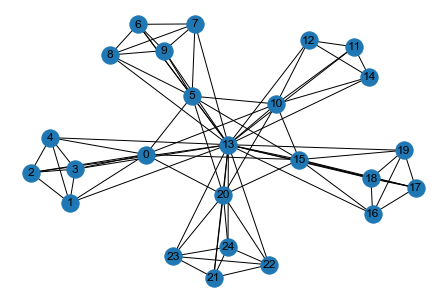

In [16]:
blh_edges = pd.read_csv('../data/clear_cluster_test/blackhorse_edges.csv', header=None, names=('from','to'))
labels = pd.read_csv('../data/clear_cluster_test/labels.csv', header=None, 
                     names=('node','label','label+'))
labels_list = list(labels['label'].unique())
n_clusters = len(labels['label'].unique())

blh_G = make_graph(labels, blh_edges)
draw_g(blh_G)

In [17]:
blh_model,blh_model_nodes = count_embeddings(m_G,labels,dimensions,
                                                                  walk_length,num_walks,p,q,workers,
                                                                  window,min_count,seed)

Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 2273.83it/s]


In [18]:
known_labels = []

for i in blh_model.wv.index2word:
    known_labels.append(labels.loc[int(i)]['label'])
    
known_labels

[1, 2, 3, 0, 4, 1, 1, 1, 3, 2, 1, 3, 2, 2, 3, 2, 4, 4, 3, 0, 0, 4, 4, 0, 0]

In [19]:
# most_similar()
keys = list(range(0,24,5)) # the first node of each group

embedding_clusters = []
word_clusters = []
for word in keys:
    print('word ',word)
    embeddings = []
    words = []
    embeddings.append(blh_model[str(word)]) # adding vector of the first(key) node
    words.append(str(word)) # adding vector of the first(key) node
    for similar_word, prob in blh_model.most_similar(str(word), topn=4): # или добавлять в зависимости от вероятности 
        words.append(similar_word)
        print(similar_word)
        embeddings.append(blh_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

word  0
4
2
3
1
word  5
6
8
9
7
word  10
11
13
12
14
word  15
19
17
16
18
word  20
24
21
22
23


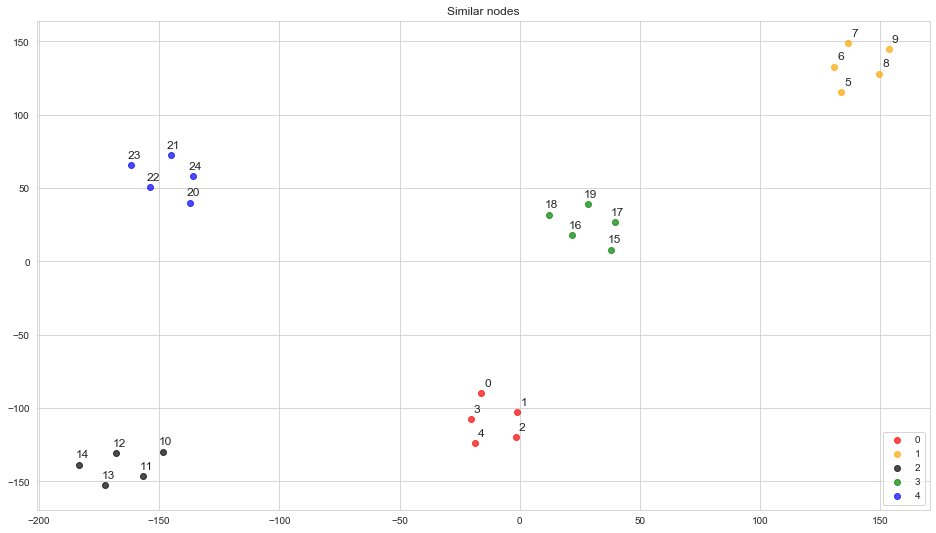

In [20]:
model_en_2d = to2d(embedding_clusters,5)
colors = assign_colors(blh_model.wv.vocab,labels)
tsne_plot_similar_words('Similar nodes', labels_list, model_en_2d, word_clusters, colors, 0.7)

In [21]:
kmean_init = []
# init kmeans centroids with the first nodes of each cluster: 
# keys = [0, 5, 10, 15, 20],
# so the cluster name is known and is right 
for i in keys:
    kmean_init.append(blh_model.wv[str(i)])
init = np.array(kmean_init)
    
km = KMeans(n_clusters=n_clusters,init=init).fit_predict(blh_model.wv.vectors)
km_map = dict(zip(blh_model.wv.index2word, km))

for cluster in [0,1,2,3,4]:
    print('cluster: ', cluster)
    for i in km_map:
        if km_map[i] == cluster:
            print(i)

cluster:  0
0
1
4
3
2
cluster:  1
5
7
6
8
9
cluster:  2
10
14
12
13
11
cluster:  3
15
17
16
19
18
cluster:  4
20
21
22
23
24


In [22]:
print(count_scores(known_labels, km)) 

(1.0, 1.0)


# 3. Fun together
1/4 of the links are random 

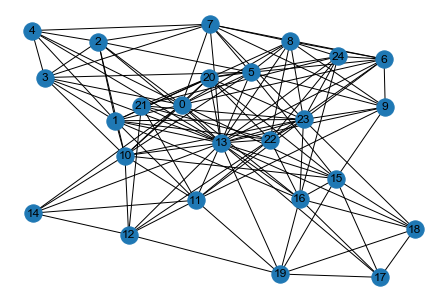

In [23]:
r_edges = pd.read_csv('../data/clear_cluster_test/fun_together_edges.csv', header=None, names=('from','to'))
labels = pd.read_csv('../data/clear_cluster_test/labels.csv', header=None, 
                     names=('node','label','label+'))
labels_list = list(labels['label'].unique())
n_clusters = len(labels['label'].unique())

r_G = make_graph(labels, r_edges)
draw_g(r_G)

In [24]:
r_model,r_model_nodes = count_embeddings(r_G,labels,dimensions,
                                                                  walk_length,num_walks,p,q,workers,
                                                                  window,min_count,seed)

Computing transition probabilities: 100%|██████████| 25/25 [00:00<00:00, 1042.27it/s]


In [25]:
r_known_labels = []

for i in r_model.wv.index2word:
    r_known_labels.append(labels.loc[int(i)]['label'])
    
r_known_labels

[2, 4, 0, 1, 2, 0, 4, 1, 3, 2, 3, 1, 4, 1, 4, 0, 0, 1, 3, 2, 4, 3, 0, 2, 3]

As it was expected clustering with the __most_similar()__ doesn't work for more complex data

In [26]:
keys = list(range(0,24,5)) # the first node of each group

embedding_clusters = []
word_clusters = []
for word in keys:
    print('word ',word)
    embeddings = []
    words = []
    embeddings.append(r_model[str(word)]) # adding vector of the first(key) node
    words.append(str(word)) # adding vector of the first(key) node
    for similar_word, prob in r_model.most_similar(str(word), topn=4): # или добавлять в зависимости от вероятности 
        words.append(similar_word)
        print(similar_word)
        embeddings.append(r_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

word  0
4
7
6
5
word  5
4
2
0
9
word  10
14
1
20
21
word  15
19
16
17
11
word  20
21
1
14
23


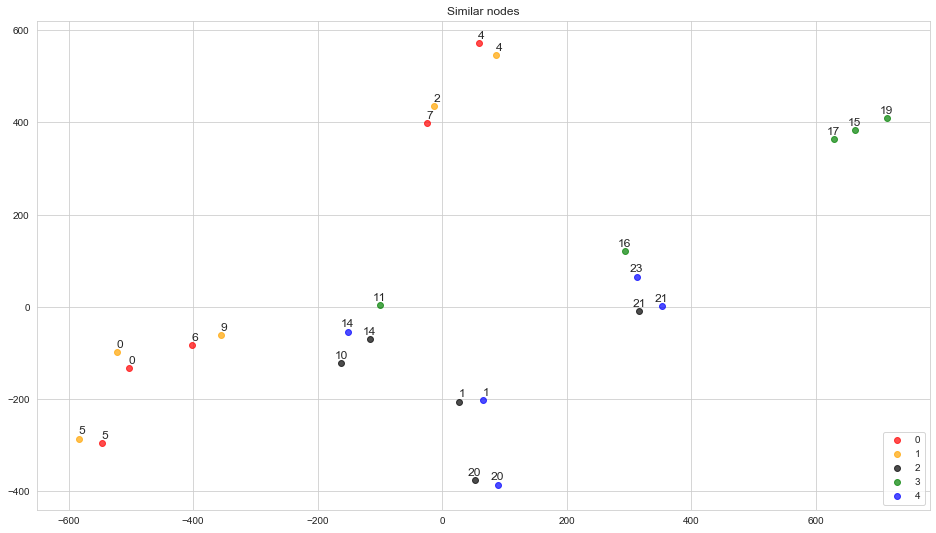

In [27]:
model_en_2d = to2d(embedding_clusters,2)
colors = assign_colors(r_model.wv.vocab,labels)
tsne_plot_similar_words('Similar nodes', labels_list, model_en_2d, word_clusters, colors, 0.7)

In [28]:
kmean_init = []
# init kmeans centroids with the first nodes of each cluster: 
# keys = [0, 5, 10, 15, 20],
# so the cluster name is known and is right 
for i in keys:
    kmean_init.append(r_model.wv[str(i)])
init = np.array(kmean_init)
    
km = KMeans(n_clusters=n_clusters,init=init).fit_predict(r_model.wv.vectors)
km_map = dict(zip(r_model.wv.index2word, km))

for cluster in [0,1,2,3,4]:
    print('cluster: ', cluster)
    for i in km_map:
        if km_map[i] == cluster:
            print(i)

cluster:  0
0
1
22
6
24
cluster:  1
5
9
cluster:  2
10
11
12
14
cluster:  3
15
19
17
cluster:  4
13
23
7
16
8
20
2
3
21
18
4


In [29]:
# f1_micro, adj_rand
print(count_scores(r_known_labels, km)) 

(0.56, 0.15)


# 4. Emails data set (fingers crossed)

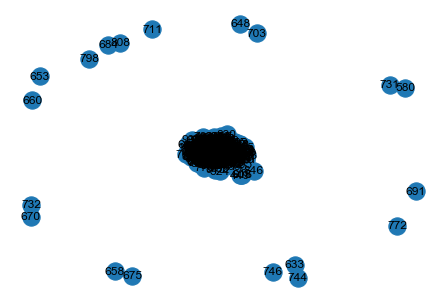

In [30]:
emails_edges = pd.read_csv('../data/emails/edges.csv', header=None, names=('from','to'))
emails_labels = pd.read_csv('../data/emails/labels.csv', header=None, 
                     names=('node','label'))
emails_labels = emails_labels.sort_values(by='label')

emails_labels_list = list(emails_labels['label'].unique())
emails_n_clusters = len(emails_labels['label'].unique())

emails_G = make_graph(emails_labels, emails_edges)
draw_g(emails_G)

In [ ]:
emails_model,emails_model_nodes = count_embeddings(emails_G,labels,dimensions,
                                                                  walk_length,num_walks,p,q,workers,
                                                                  window,min_count,seed)

Computing transition probabilities: 100%|██████████| 1005/1005 [00:14<00:00, 70.50it/s]


In [ ]:
emails_known_labels = []

for i in emails_model.wv.index2word:
    emails_known_labels.append(emails_labels.loc[int(i)]['label'])
    
# print(emails_known_labels)

In [ ]:
keys = []

labels_list = emails_labels['label'].unique()

for i in labels_list:
    keys.append(list(emails_labels[emails_labels['label']==i]['node'])[0])
print(keys)

In [ ]:
kmean_init = []
# init kmeans centroids with the first nodes of each cluster: 
# so the cluster name is known and is right 
for i in keys:
    kmean_init.append(emails_model.wv[str(i)])
init = np.array(kmean_init)
    
emails_km = KMeans(n_clusters=emails_n_clusters,init=init).fit_predict(emails_model.wv.vectors)
km_map = dict(zip(emails_model.wv.index2word, emails_km))

In [ ]:
print(count_scores(emails_known_labels, emails_km)) 